In [1]:
import os
import time
import collections
import itertools
print("Running on ", time.asctime())

import numpy             as np
import matplotlib.pyplot as plt

import invisible_cities.database.load_db        as DB
import invisible_cities.core    .core_functions as coref
import invisible_cities.core    .fit_functions  as fitf
import invisible_cities.reco    .corrections    as corrf
import invisible_cities.reco    .dst_functions  as dstf

from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import hist2d
from invisible_cities.icaro. hst_functions import pdf
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import resolution
from invisible_cities.icaro. hst_functions import gausstext
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer
from invisible_cities.icaro. hst_functions import measurement_string

from icaro.core.fit_functions import conditional_labels

Running on  Tue Mar 27 19:33:32 2018


In [2]:
labels = conditional_labels(True)

In [3]:
filename_mc   = os.path.expandvars("$IC_DATA/XYmaps/corrections_MC.h5")
filename_data = os.path.expandvars("$IC_DATA/XYmaps/corrections_run4734.h5")

In [4]:
%matplotlib inline

default_cmap = "jet"
figure_size  = 16, 12
font_size    = 20

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

In [5]:
xymap_mc   = dstf.load_dst(filename_mc,
                           group = "XYcorrections",
                           node  = "GeometryE_5.0mm")

xymap_data = dstf.load_dst(filename_data,
                           group = "XYcorrections",
                           node  = "GeometryE_5.0mm")

In [45]:
def normalize(values, uncerts, xcenter, ycenter):
    to = tuple(itertools.product((xcenter - 1, xcenter, xcenter + 1),
                                 (ycenter - 1, ycenter, xcenter + 1)))
    normalization_value  = np.mean([values [i] for i in to])
    normalization_uncert = np.mean([uncerts[i] for i in to])

    ok                     = values > 0
    normalized_values      = np.zeros_like(values)
    normalized_uncerts     = np.zeros_like(uncerts)
    normalized_values [ok] = values[ok] / normalization_value
    normalized_uncerts[ok] = (uncerts[ok] / values[ok])**2 + (normalization_uncert / normalization_value)**2
    normalized_uncerts     = normalized_values * normalized_uncerts**0.5
    return normalized_values, normalized_uncerts

In [46]:
x           = np.unique(xymap_mc.x.values)
y           = np.unique(xymap_mc.y.values)
values_mc   = xymap_mc  .factor     .values.reshape(x.size, y.size)
uncert_mc   = xymap_mc  .uncertainty.values.reshape(x.size, y.size)
values_data = xymap_data.factor     .values.reshape(x.size, y.size)
uncert_data = xymap_data.uncertainty.values.reshape(x.size, y.size)

values_mc  , uncert_mc   = normalize(values_mc  , uncert_mc  , x.size // 2, y.size // 2)
values_data, uncert_data = normalize(values_data, uncert_data, x.size // 2, y.size // 2)

ok    = (values_mc > 0) & (uncert_data**2 + uncert_mc**2 > 0)
ratio = np.where(ok,  values_data / values_mc, 0)
pull  = np.where(ok, (values_data - values_mc) / np.sqrt(uncert_data**2 + uncert_mc**2), -100)

/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


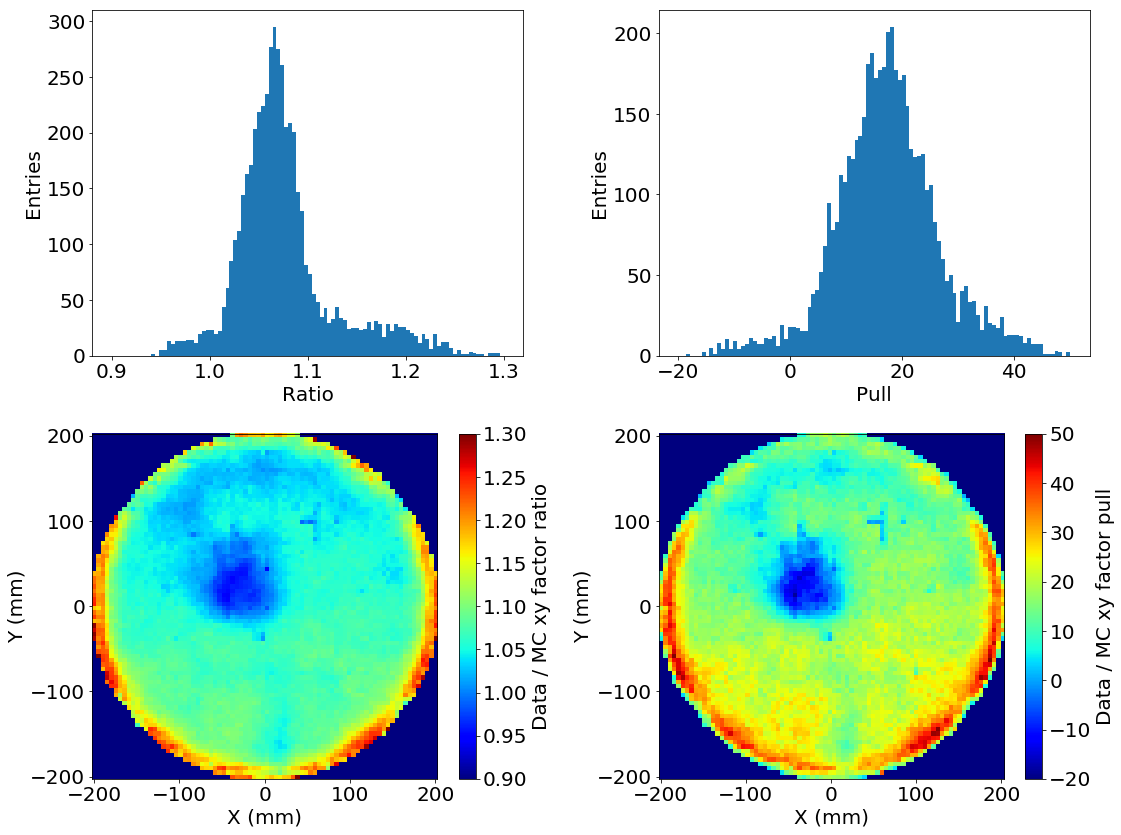

In [50]:
ratio_limits = 0.9, 1.3
pull_limits  = -20, 50

plt.subplot(2, 2, 1)
hist(ratio.flatten(), np.linspace(*ratio_limits, 101), new_figure=False)
labels("Ratio", "Entries")


plt.subplot(2, 2, 2)
hist(pull.flatten(), np.linspace(*pull_limits, 101), new_figure=False)
labels("Pull", "Entries")

plt.subplot(2, 2, 3)
*_, cb = display_matrix(x, y, ratio,
                        vmin = ratio_limits[0],
                        vmax = ratio_limits[1],
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Data / MC xy factor ratio")
labels("X (mm)", "Y (mm)")

plt.subplot(2, 2, 4)
*_, cb = display_matrix(x, y, pull,
                        vmin = pull_limits[0],
                        vmax = pull_limits[1],
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("Data / MC xy factor pull")
labels("X (mm)", "Y (mm)")

plt.tight_layout()

plt.savefig("/Users/Gonzalo/Desktop/data_mc_ratio.png")

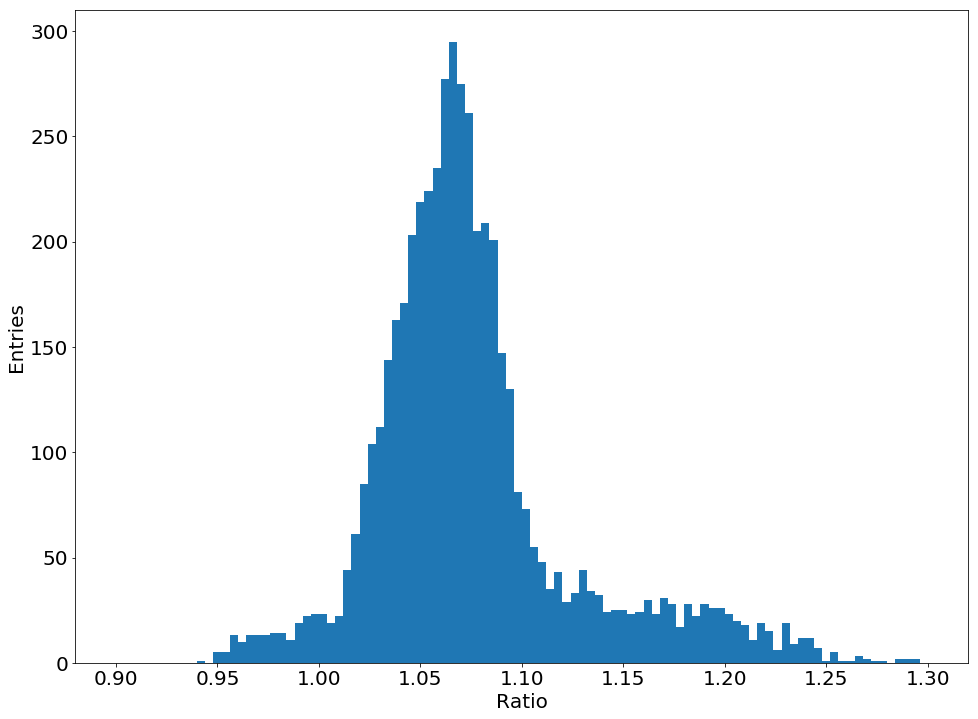

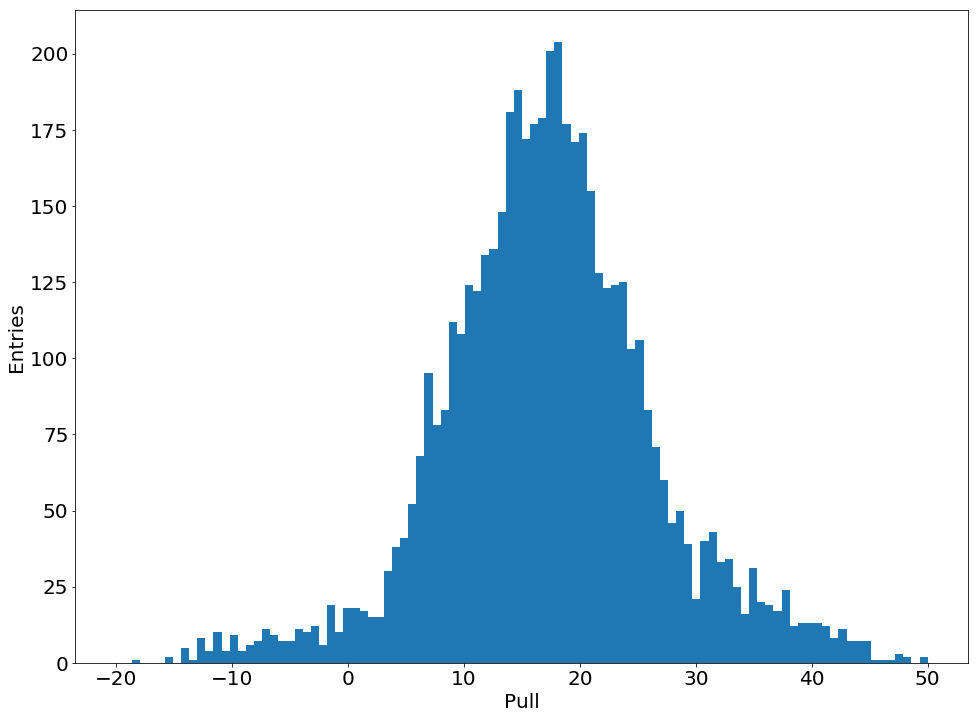

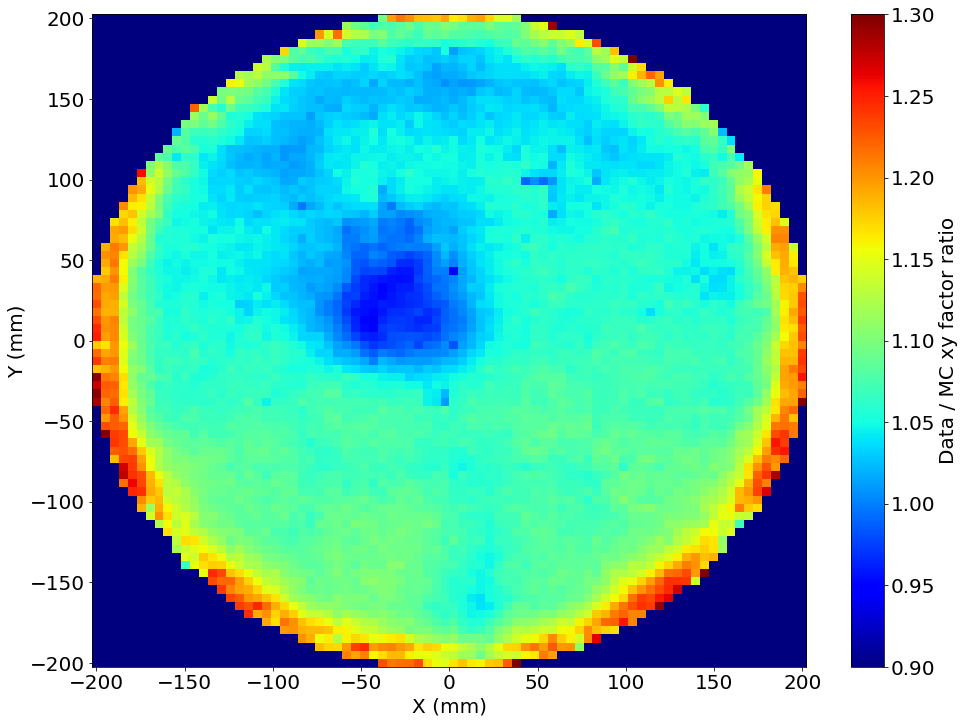

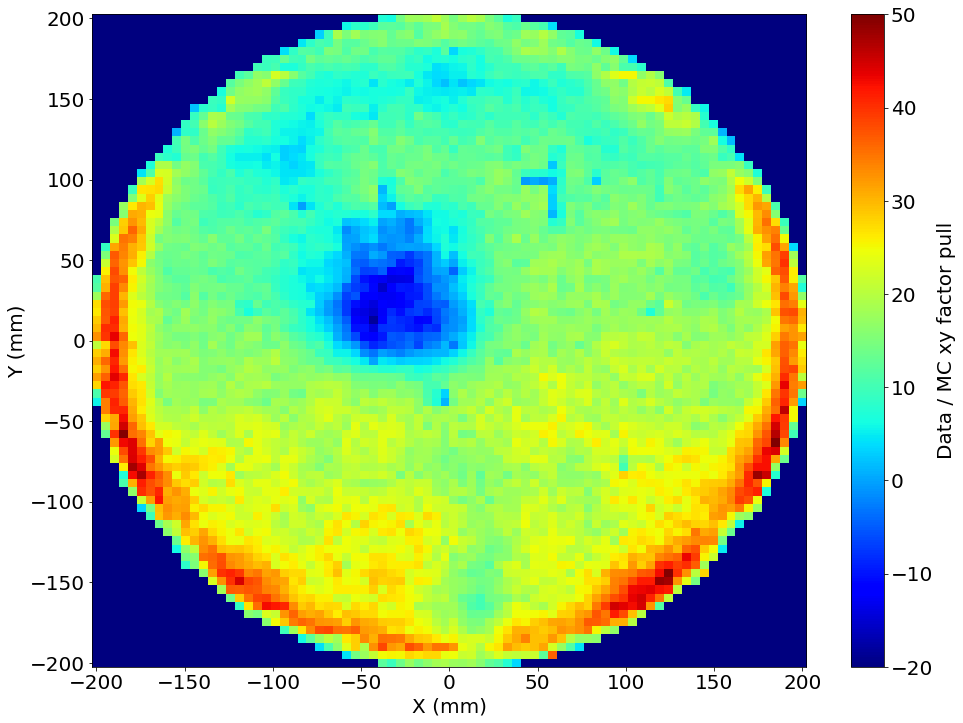

In [57]:
ratio_limits = 0.9, 1.3
pull_limits  = -20, 50

hist(ratio.flatten(), np.linspace(*ratio_limits, 101))
labels("Ratio", "Entries")
plt.savefig("/Users/Gonzalo/Desktop/data_mc_ratio_hist.png")

hist(pull.flatten(), np.linspace(*pull_limits, 101))
labels("Pull", "Entries")
plt.savefig("/Users/Gonzalo/Desktop/data_mc_pull_hist.png")

*_, cb = display_matrix(x, y, ratio,
                        vmin = ratio_limits[0],
                        vmax = ratio_limits[1],
                        cmap = default_cmap)
cb.set_label("Data / MC xy factor ratio")
labels("X (mm)", "Y (mm)")
plt.savefig("/Users/Gonzalo/Desktop/data_mc_ratio_2d.png")

*_, cb = display_matrix(x, y, pull,
                        vmin = pull_limits[0],
                        vmax = pull_limits[1],
                        cmap = default_cmap)
cb.set_label("Data / MC xy factor pull")
labels("X (mm)", "Y (mm)")
plt.savefig("/Users/Gonzalo/Desktop/data_mc_pull_2d.png")

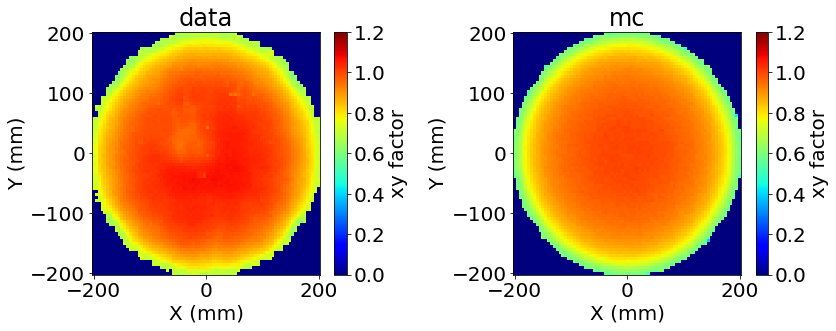

In [56]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
*_, cb = display_matrix(x, y, values_data,
                        vmin = 0,
                        vmax = 1.2,
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("xy factor")
labels("X (mm)", "Y (mm)", "data")

plt.subplot(1, 2, 2)
*_, cb = display_matrix(x, y, values_mc,
                        vmin = 0,
                        vmax = 1.2,
                        cmap = default_cmap,
                        new_figure=False)
cb.set_label("xy factor")
labels("X (mm)", "Y (mm)", "mc")

plt.tight_layout()

plt.savefig("/Users/Gonzalo/Desktop/data_mc_maps.png")

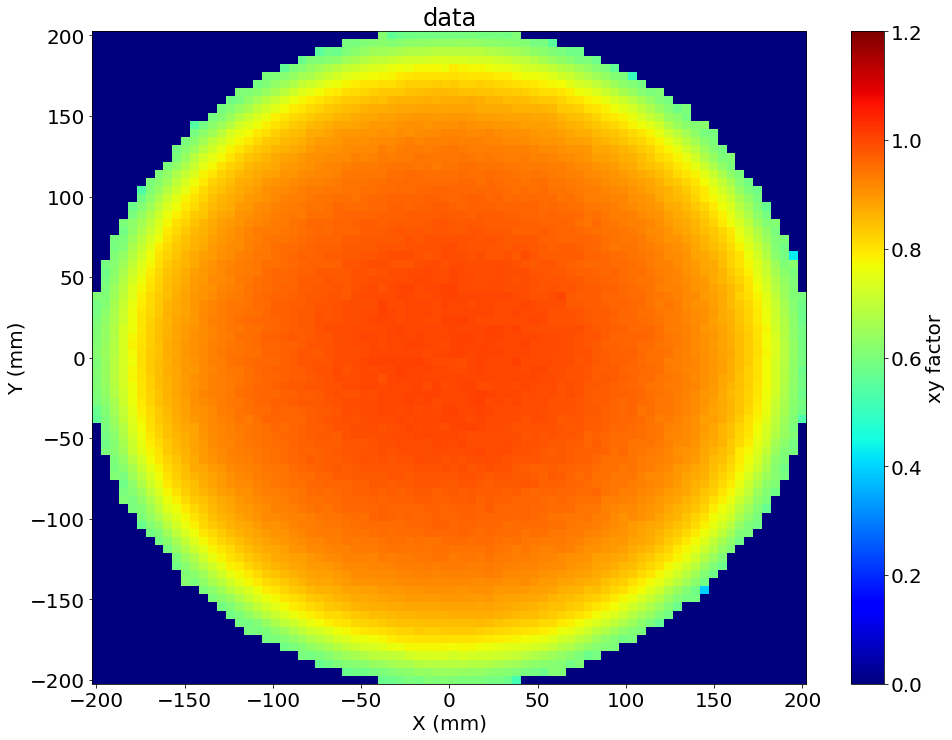

In [58]:
*_, cb = display_matrix(x, y, values_mc,
                        vmin = 0,
                        vmax = 1.2,
                        cmap = default_cmap)
cb.set_label("xy factor")
labels("X (mm)", "Y (mm)", "data")
plt.savefig("/Users/Gonzalo/Desktop/mc_map.png")